In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

## Loading and saving images as .npy files so we could deal with them

In [ ]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [ ]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
trainpath='F:/chestdata/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [ ]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
testpath='F:/chestdata/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

The .npy files are then uploaded to Google Drive

## Loading the .npy files as numpy arrays

In [ ]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('/content/drive/MyDrive/chest_data/X_train.npy')
loaded_X_test = np.load('/content/drive/MyDrive/chest_data/X_test.npy')
loaded_y_train = np.load('/content/drive/MyDrive/chest_data/y_train.npy')
loaded_y_test = np.load('/content/drive/MyDrive/chest_data/y_test.npy')

In [ ]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels. 
#while the forth dimension stores the RGB information of each pixel

(5216, 64, 64, 3)


In [ ]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


In [ ]:
#y_train and y_test contain the labels of each image, whether 0 'NORMAL' or 1 'PNEUMONIA'
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(5216,)
(624,)


## Data Analysis

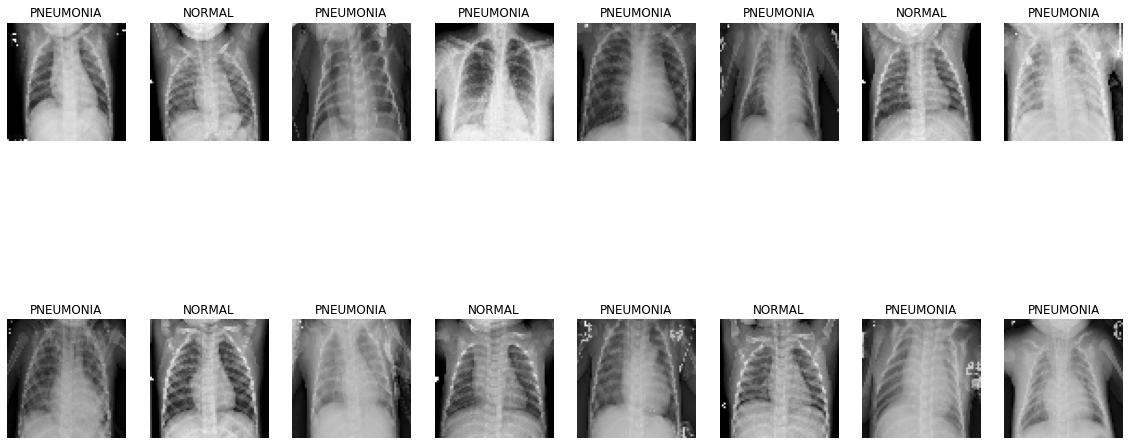

In [ ]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


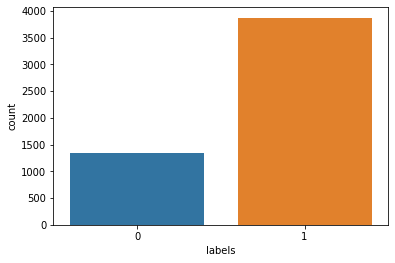

In [ ]:
#count plot to show the number of pneumonia cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

As we can see pnuemonia cases are over represented in the train data set. We will deal with such imbalance later

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


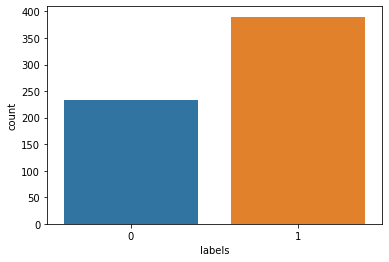

In [ ]:
#count plot to show the number of pneumonia cases to normal cases in the test data set

df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
lab = df_test['labels']
dist = lab.value_counts()
#play with pallette colors
sns.countplot(lab)
plt.show()

In [ ]:
#function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)


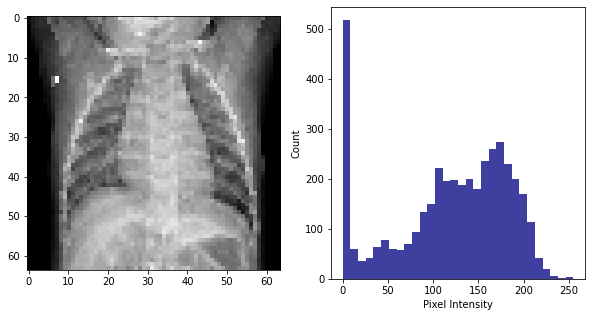

In [ ]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

## Flatten and shuffle train and test sets 

In [ ]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [ ]:
y_train = loaded_y_train
y_test = loaded_y_test

In [ ]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

## Testing classification algorithms without any preprocessing 

In [ ]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

KNN accuracy score is: 0.7339743589743589
Logistic Regression accuracy score is: 0.7451923076923077
Decision Tree Classifier accuracy score is: 0.7323717948717948
Random forests Classifier accuracy score is: 0.780448717948718
Support Vector Machine Classifier accuracy score is: 0.7612179487179487


The highest accuracy score obtaiend is from the random forests classifier. As accuracy score is not enough to judge a model we will use confusion matrix

In [ ]:
#making predictions for each model
knn_predcited = knn.predict(X_test)
log_reg_predcited = log_reg.predict(X_test)
dtc_predcited = dtc.predict(X_test)
rfc_predcited = rfc.predict(X_test)
svm_predcited = svm.predict(X_test)

In [ ]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

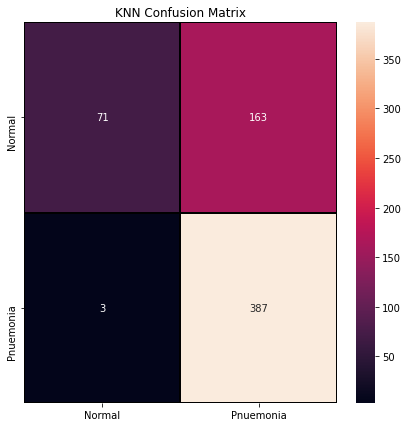

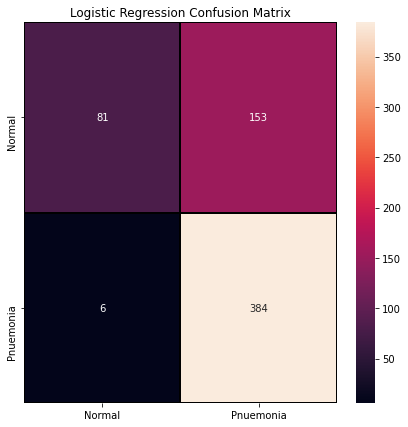

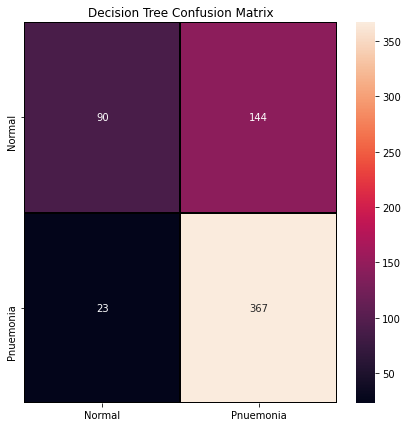

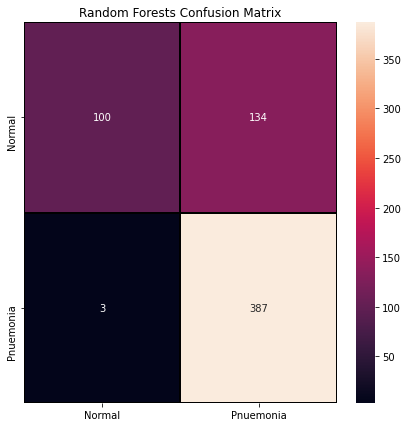

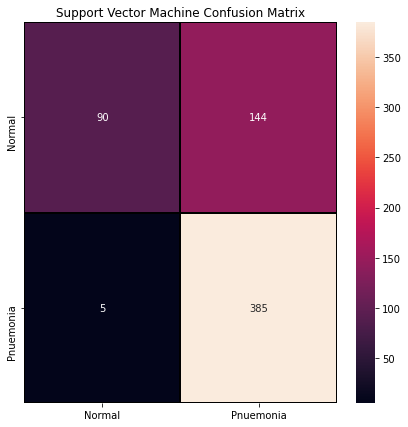

In [ ]:
#plot confusion matrix for each model

plot_cm(knn_predcited, y_test, 'KNN Confusion Matrix')

plot_cm(log_reg_predcited, y_test, 'Logistic Regression Confusion Matrix') 
    
plot_cm(dtc_predcited, y_test, 'Decision Tree Confusion Matrix')

plot_cm(rfc_predcited, y_test, 'Random Forests Confusion Matrix')

plot_cm(svm_predcited, y_test, 'Support Vector Machine Confusion Matrix')

from looking at the confusion matrix we could say that the best classifier without any data preprofcessing is the random forests classifier.

## Data Preprocessing

Since our feaures are a representation of pixel values we will scale them

In [ ]:
#Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

we will use Principle Component Analysis (PCA) to reduce the amount of features, to n number of components that represent 0.95% variance of data  

In [ ]:
#PCA    
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
#printing the variance of each component from PCA
print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 546


## Testing classification algorithms after scaling and PCA

In [ ]:
#making an instance for each algorithm
knn_PCA = KNeighborsClassifier(n_neighbors=10)
log_reg_PCA  = LogisticRegression()
dtc_PCA  = DecisionTreeClassifier()
rfc_PCA = RandomForestClassifier()
svm_PCA = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn_PCA.fit(X_train, y_train)
log_reg_PCA.fit(X_train, y_train)
dtc_PCA.fit(X_train, y_train)
rfc_PCA.fit(X_train, y_train)
svm_PCA.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_PCA.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_PCA.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_PCA.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_PCA.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_PCA.score(X_test, y_test)))

KNN accuracy score is: 0.7596153846153846
Logistic Regression accuracy score is: 0.7772435897435898
Decision Tree Classifier accuracy score is: 0.7676282051282052
Random forests Classifier accuracy score is: 0.7019230769230769
Support Vector Machine Classifier accuracy score is: 0.7996794871794872


The highest accuracy score obtaiend is from the support vector machine. As accuracy score is not enough to judge a model we will use confusion matrix

In [ ]:
#making predictions for each model
knn_PCA_predcited = knn_PCA.predict(X_test)
log_reg_PCA_predcited = log_reg_PCA.predict(X_test)
dtc_PCA_predcited = dtc_PCA.predict(X_test)
rfc_PCA_predcited = rfc_PCA.predict(X_test)
svm_PCA_predcited = svm_PCA.predict(X_test)

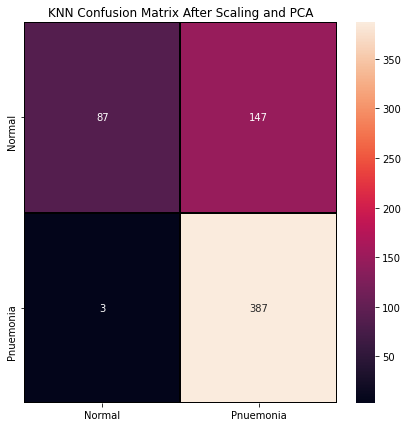

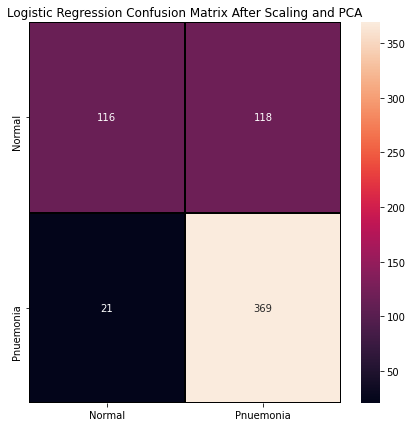

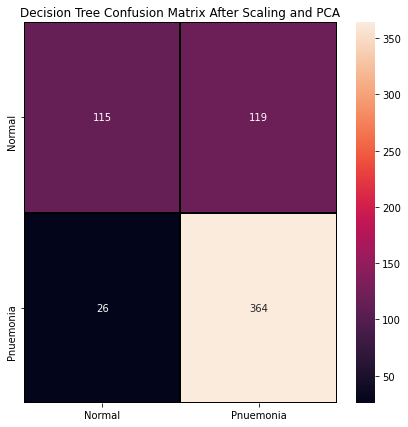

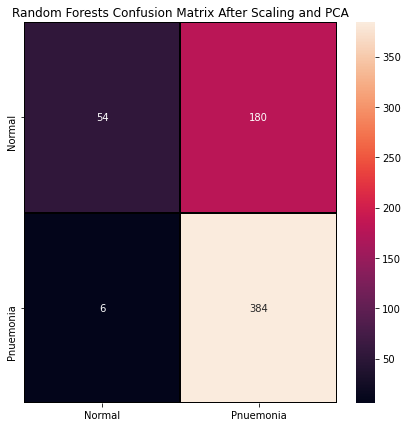

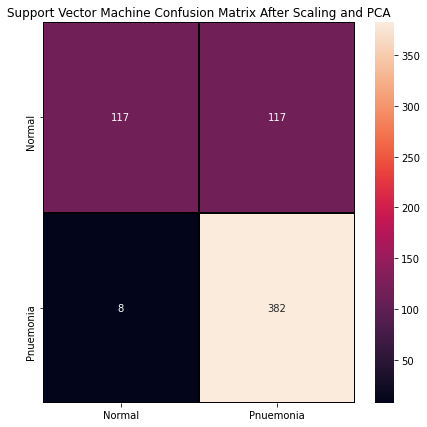

In [ ]:
#plot confusion matrix for each model after scaling and PCA

plot_cm(knn_PCA_predcited, y_test, 'KNN Confusion Matrix After Scaling and PCA')

plot_cm(log_reg_PCA_predcited, y_test, 'Logistic Regression Confusion Matrix After Scaling and PCA') 
    
plot_cm(dtc_PCA_predcited, y_test, 'Decision Tree Confusion Matrix After Scaling and PCA')

plot_cm(rfc_PCA_predcited, y_test, 'Random Forests Confusion Matrix After Scaling and PCA')

plot_cm(svm_PCA_predcited, y_test, 'Support Vector Machine Confusion Matrix After Scaling and PCA')

Since our data is imbalanced with pneumonia cases outnumbering normal cases, we will uses sampling techniques to try to overcome such imbalance

1 - Oversampling using SMOTE

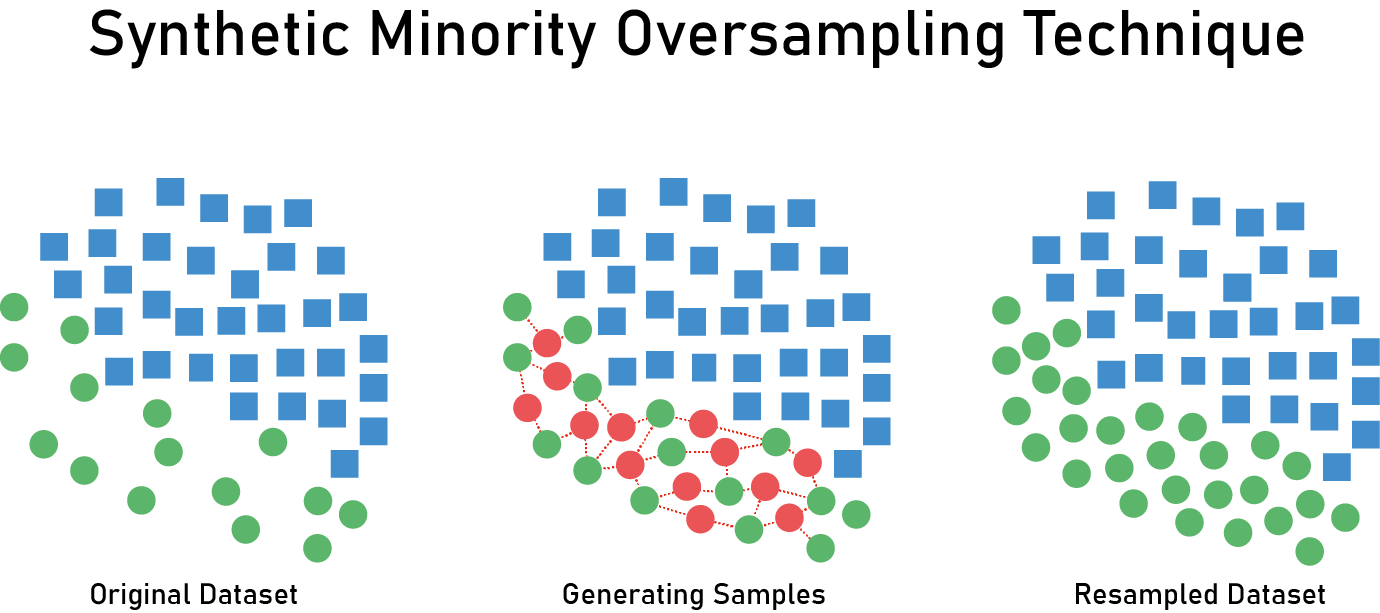

In [ ]:
#applying SMOTE to X_train and y_train to generate new samples to overcome the imbalance
smote = SMOTE(random_state = 11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#printing X_train and y_train shape after SMOTE
print(X_train_smote.shape)
print(y_train_smote.shape)

(7750, 546)
(7750,)


## Testing classification algorithms after SMOTE

In [ ]:
#making an instance for each algorithm
knn_smote = KNeighborsClassifier(n_neighbors=10)
log_reg_smote  = LogisticRegression()
dtc_smote  = DecisionTreeClassifier()
rfc_smote = RandomForestClassifier()
svm_smote = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn_smote.fit(X_train_smote, y_train_smote)
log_reg_smote.fit(X_train_smote, y_train_smote)
dtc_smote.fit(X_train_smote, y_train_smote)
rfc_smote.fit(X_train_smote, y_train_smote)
svm_smote.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_smote.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_smote.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_smote.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_smote.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_smote.score(X_test, y_test)))

KNN accuracy score is: 0.8237179487179487
Logistic Regression accuracy score is: 0.7836538461538461
Decision Tree Classifier accuracy score is: 0.7596153846153846
Random forests Classifier accuracy score is: 0.7371794871794872
Support Vector Machine Classifier accuracy score is: 0.8108974358974359


The highest accuracy score obtaiend is from the KNN. As accuracy score is not enough to judge a model we will use confusion matrix

In [ ]:
#making predictions for each model
knn_smote_predcited = knn_smote.predict(X_test)
log_reg_smote_predcited = log_reg_smote.predict(X_test)
dtc_smote_predcited = dtc_smote.predict(X_test)
rfc_smote_predcited = rfc_smote.predict(X_test)
svm_smote_predcited = svm_smote.predict(X_test)

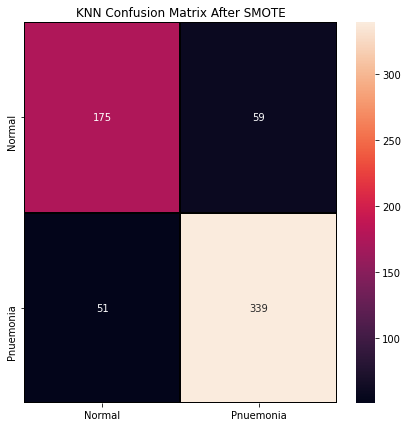

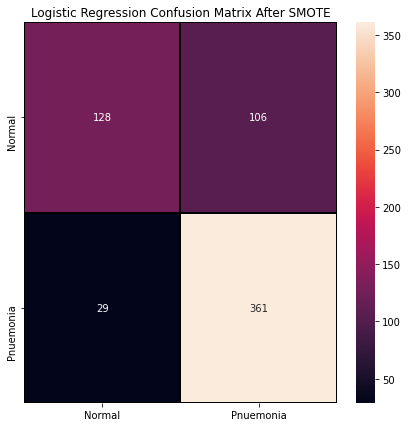

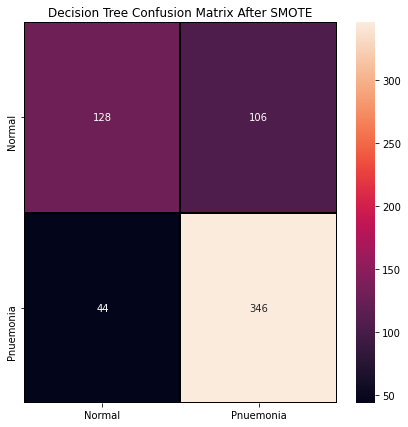

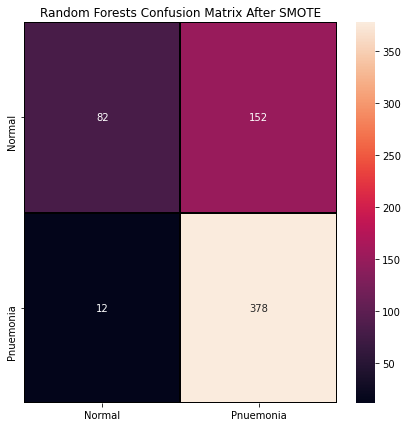

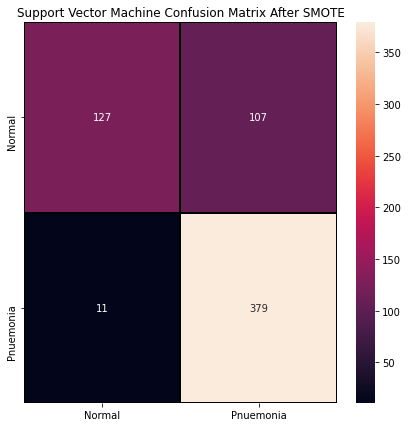

In [ ]:
#plot confusion matrix for each model after SMOTE

plot_cm(knn_smote_predcited, y_test, 'KNN Confusion Matrix After SMOTE')

plot_cm(log_reg_smote_predcited, y_test, 'Logistic Regression Confusion Matrix After SMOTE') 
    
plot_cm(dtc_smote_predcited, y_test, 'Decision Tree Confusion Matrix After SMOTE')

plot_cm(rfc_smote_predcited, y_test, 'Random Forests Confusion Matrix After SMOTE')

plot_cm(svm_smote_predcited, y_test, 'Support Vector Machine Confusion Matrix After SMOTE')

Looking at the confusion matrix of KNN and SVM models, it's hard to say which model is better as both models are good in certain areas and are flawed in others

2 SMOTE and TOMEK LINKS

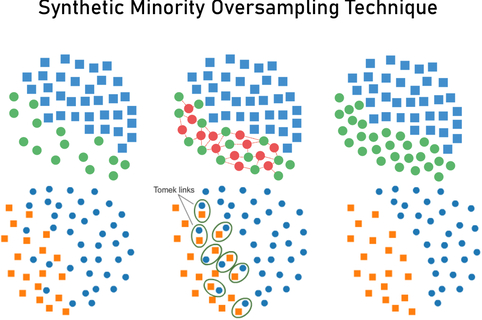

In [ ]:
#creating the resample object for SMOTE TOMEK LINKS
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [ ]:
#fitting and resampling the SMOTETomek object to the train data
X_smote_tomek, y_smote_tomek= resample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#printing shape of data from SMOTE and TOMEK LINKS
print(X_smote_tomek.shape)
print(y_smote_tomek.shape)

(7749, 546)
(7749,)


## Training classification Algorithms using data from SMOTE and TOMEK LINKS

In [ ]:
#making an instance for each algorithm
knn_smote_tomek = KNeighborsClassifier(n_neighbors=10)
log_reg_smote_tomek  = LogisticRegression()
dtc_smote_tomek  = DecisionTreeClassifier()
rfc_smote_tomek = RandomForestClassifier()
svm_smote_tomek = SVC()

In [ ]:
#fitting each model using data from SMOTE and TOMEK LINKS
knn_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
log_reg_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
dtc_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
rfc_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
svm_smote_tomek.fit(X_smote_tomek, y_smote_tomek)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_smote_tomek.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_smote_tomek.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_smote_tomek.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_smote_tomek.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_smote_tomek.score(X_test, y_test)))

KNN accuracy score is: 0.8349358974358975
Logistic Regression accuracy score is: 0.7836538461538461
Decision Tree Classifier accuracy score is: 0.7564102564102564
Random forests Classifier accuracy score is: 0.7772435897435898
Support Vector Machine Classifier accuracy score is: 0.8076923076923077


The highest accuracy score obtaiend is from the KNN. As accuracy score is not enough to judge a model we will use confusion matrix

In [ ]:
#making predictions for each model
knn_smote_tomek_predcited = knn_smote_tomek.predict(X_test)
log_reg_smote_tomek_predcited = log_reg_smote_tomek.predict(X_test)
dtc_smote_tomek_predcited = dtc_smote_tomek.predict(X_test)
rfc_smote_tomek_predcited = rfc_smote_tomek.predict(X_test)
svm_smote_tomek_predcited = svm_smote_tomek.predict(X_test)

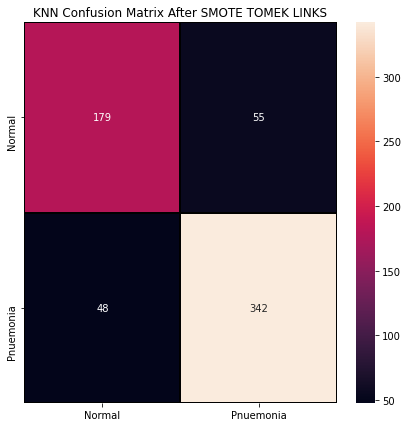

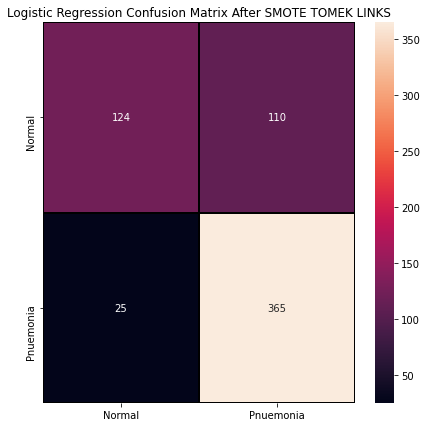

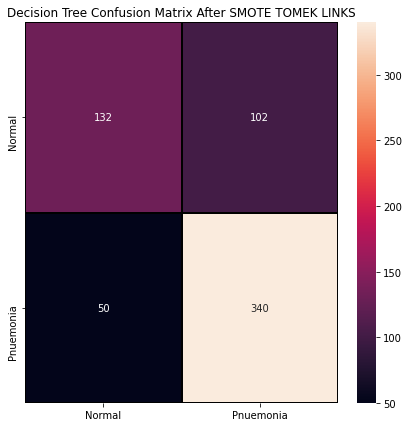

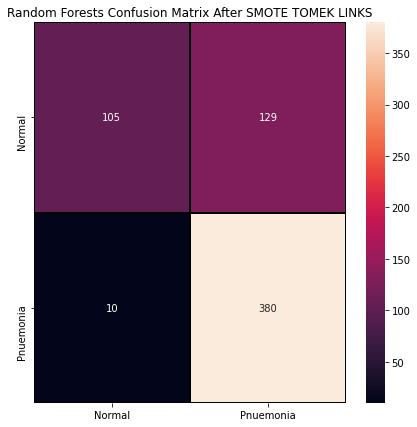

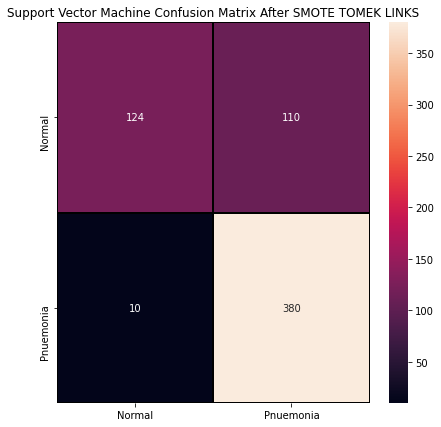

In [ ]:
#plot confusion matrix for each model after SMOTE

plot_cm(knn_smote_tomek_predcited, y_test, 'KNN Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(log_reg_smote_tomek_predcited, y_test, 'Logistic Regression Confusion Matrix After SMOTE TOMEK LINKS') 
    
plot_cm(dtc_smote_tomek_predcited, y_test, 'Decision Tree Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(rfc_smote_tomek_predcited, y_test, 'Random Forests Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(svm_smote_tomek_predcited, y_test, 'Support Vector Machine Confusion Matrix After SMOTE TOMEK LINKS')

The best results are obtained from KNN and SVM models

Printing the classification report for each of the two models to compare between them

In [ ]:
#KNN classification report 
print(classification_report(y_test, knn_smote_tomek_predcited, target_names= ['Normal (0)', 'Pneumonia (1)']))

               precision    recall  f1-score   support

   Normal (0)       0.79      0.76      0.78       234
Pneumonia (1)       0.86      0.88      0.87       390

     accuracy                           0.83       624
    macro avg       0.83      0.82      0.82       624
 weighted avg       0.83      0.83      0.83       624



In [ ]:
#SVM classification report 
print(classification_report(y_test, svm_smote_tomek_predcited, target_names= ['Normal (0)', 'Pneumonia (1)']))

               precision    recall  f1-score   support

   Normal (0)       0.93      0.53      0.67       234
Pneumonia (1)       0.78      0.97      0.86       390

     accuracy                           0.81       624
    macro avg       0.85      0.75      0.77       624
 weighted avg       0.83      0.81      0.79       624



We will try to optimize KNN and SVM model to select the best of them

## KNN Model Optimization

In [ ]:
#function to visualise the best K for the KNN model
def plot_K(X_train, y_train, X_test, y_test):
  error1= []
  error2= []
  for k in range(1,15):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred1= knn.predict(X_train)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(X_test)
    error2.append(np.mean(y_test!= y_pred2))

  plt.plot(range(1,15),error1,label="train")
  plt.plot(range(1,15),error2,label="test")
  plt.xlabel('k Value')
  plt.ylabel('Error')
  plt.legend()

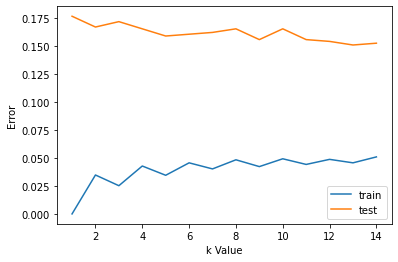

In [ ]:
plot_K(X_smote_tomek, y_smote_tomek, X_test, y_test)

from the graph the best k is 9

In [ ]:
#creating a KNN model with K = 9
KNN_model = KNeighborsClassifier(n_neighbors=9)
#fitting the model with the processed data
KNN_model.fit(X_smote_tomek, y_smote_tomek)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
#scoring the KNN model
print('KNN accuracy score is: ' + str(KNN_model.score(X_test, y_test)))

KNN accuracy score is: 0.844551282051282


In [ ]:
#making predictions for optimized KNN model
KNN_model_predcited = KNN_model.predict(X_test)

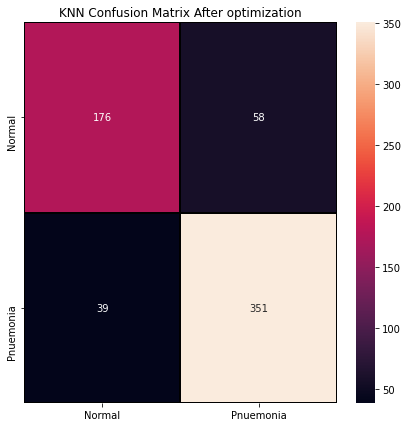

In [ ]:
#plot confusion matrix for KNN model

plot_cm(KNN_model_predcited, y_test, 'KNN Confusion Matrix After optimization')

# SVM Model Optimization

we will use grid search to try to optimize the SVM model

In [ ]:
#define the svm parameters for grid search
SVM_param_grid = { 
    'C':[0.1,1,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }

In [ ]:
#creating the grid serach object
SVM_grid_search = GridSearchCV(svm_smote_tomek, param_grid = SVM_param_grid, cv = 3, verbose=True, n_jobs=-1, refit=True)

In [ ]:
#fitting the grid search object with processed data
SVM_grid_search.fit(X_smote_tomek, y_smote_tomek)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 98.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 154.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 179.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [ ]:
#printing the best paramters from the SVM grid search
SVM_grid_search.best_params_

{'C': 100, 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
#getting the best model from the SVM grid search
best_SVM_model = SVM_grid_search.best_estimator_

In [ ]:
#scoring the best SVM model from grid search
print(best_SVM_model.score(X_test, y_test))

0.7996794871794872


as we can see the best model out of KNN and SVM models is the KNN one. Thusly, our project will run on the KNN model

## Evaluating the best model

In [ ]:
#scoring the KNN model
print('KNN accuracy score is: ' + str(KNN_model.score(X_test, y_test)))

KNN accuracy score is: 0.844551282051282


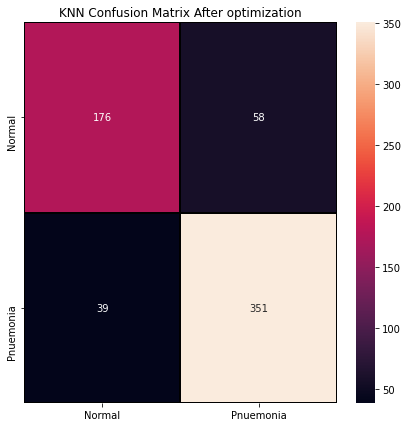

In [ ]:
#plot confusion matrix for KNN model

plot_cm(KNN_model_predcited, y_test, 'KNN Confusion Matrix After optimization')

In [ ]:
#printing the classification report
print(classification_report(y_test, KNN_model_predcited))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       234
           1       0.86      0.90      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



Learning Curve of the KNN model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


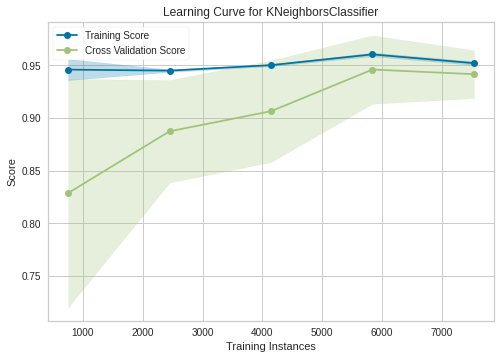

AxesSubplot(0.125,0.125;0.775x0.755)


In [ ]:
#creating two arrays that hold all the processed data and the labels respectively
X = np.concatenate((X_smote_tomek, X_test))
y = np.concatenate((y_smote_tomek, y_test))

#plot the learning curve
print(learning_curve(KNN_model, X, y, cv=10, scoring='accuracy'))

## Making Visualised Predictions 

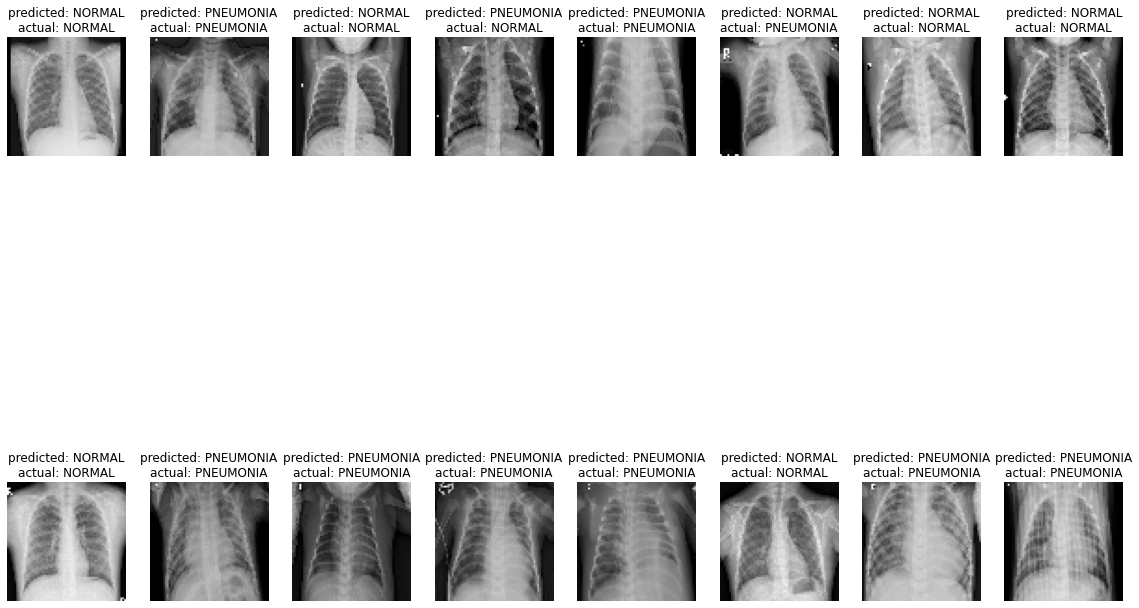

In [ ]:
#flatten
X_visual = loaded_X_test.reshape([-1, np.product((64,64,3))])

#scaling
X_visual = sc.fit_transform(X_visual)

#PCA
X_visual = pca.transform(X_visual)


#we pull 16 random images from the test data set and make predictions on them
plt.figure(figsize=(20,15))
for n , i in enumerate(np.random.randint(0,len(X_visual),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_test[i])
    plt.axis('off')
    plt.title('predicted: ' + str(getcode(KNN_model.predict([X_visual[i]]))) + '\n' + 'actual: '  + str(getcode(loaded_y_test[i])))